In [ ]:
Цель: "similarity sentences", найти и сопоставить разные по написанию, но одинаковые по смыслу предложения
Задачи:
    1. провести очистку данных от символов, регистра, убрать предложения, состоящие из пары слов(оптимизация)
    (пока для одной колонки, самой инфорнмативной "body_text")
    2. обучить модель bert на очищенных данных и сопоставить предложения с помощью cousine similarity
    3. визуализировать полученные результаты

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("D:\\wikibooks dataset\\ru-books-dataset.csv")#поменять адресс
df.head()

,title,url,abstract,body_text,body_html
0,Викиучебник: Техника и технология средств масс...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,* [станция|Рабочая станция];,Рабочая станция;\nСервер;\nПерсональный компью...,"<div class=""mw-parser-output""><ul><li><a href=..."
1,Викиучебник: АОН/Пилотское свидетельство,https://ru.wikibooks.org/wiki/%D0%90%D0%9E%D0%...,Гражданское пилотское свидетельство - разрешен...,В Википедии имеется статья по теме «Свидетельс...,"<div class=""mw-parser-output""><div class=""info..."
2,Викиучебник: Книга программиста/Структуры данн...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BD%D0%...,К оглавлению,"К оглавлению\nВсе программы, код которых вылож...","<div class=""mw-parser-output""><p><a href=""/wik..."
3,Викиучебник: Тесты НМО/Гигиенические основы и ...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,Гигиенические основы и медицинский контроль за...,Гигиенические основы и медицинский контроль за...,"<div class=""mw-parser-output""><p><b>Гигиеничес..."
4,Викиучебник: Коктейли/Пенная фея,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Пенная фея,Пенная фея\n\nДжин Old Tom — 60 г\nАбсент — 15...,"<div class=""mw-parser-output""><p><b>Пенная фея..."


In [4]:
df.shape

(7898, 5)

In [5]:
df.isnull()

,title,url,abstract,body_text,body_html
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
7893,False,False,False,False,False
7894,False,False,False,False,False
7895,False,False,False,False,False
7896,False,False,True,True,False


In [3]:
data = df[[ "title", "abstract", "body_text"]] #убрать ненужные колонки

data.head()


,title,abstract,body_text
0,Викиучебник: Техника и технология средств масс...,* [станция|Рабочая станция];,Рабочая станция;\nСервер;\nПерсональный компью...
1,Викиучебник: АОН/Пилотское свидетельство,Гражданское пилотское свидетельство - разрешен...,В Википедии имеется статья по теме «Свидетельс...
2,Викиучебник: Книга программиста/Структуры данн...,К оглавлению,"К оглавлению\nВсе программы, код которых вылож..."
3,Викиучебник: Тесты НМО/Гигиенические основы и ...,Гигиенические основы и медицинский контроль за...,Гигиенические основы и медицинский контроль за...
4,Викиучебник: Коктейли/Пенная фея,Пенная фея,Пенная фея\n\nДжин Old Tom — 60 г\nАбсент — 15...


In [10]:
print(data["body_text"][1:3].value_counts())

В Википедии имеется статья по теме «Свидетельство частного пилота»\n\n\nГражданское пилотское свидетельство - разрешение на управление определенным видом воздушного судна. Внутри этого свидетельства может быть много разных отметок (а может и не быть), которые или урезают или увеличивают количество разрешенных функций. Самое понятное и известное массам это свидетельство частного пилота. Его выдают после обучения на самолете или на вертолете. Для краткости в разговорной речи это свидетельство могут обозначать через название его иностранного аналога - ППЛ или ПиПиЭль (PPL).  Раньше это свидетельство в России называлось свидетельство пилота-любителя.\nПорядок выдачи свидетельств описан в ФАП-147. Содержимое этого документа почти целиком повторяет Приложение 1 "Выдача свидетельств авиационному персоналу" к Чикагской конвенции. За исключением того что свидетельства СВС в нем нет и это российская особенность.\nПилотские в каждой стране являются национальными. Выдает их CAA. В разных странах э

In [4]:
print(len(data["body_text"]))

7898


In [ ]:
Очистка данных

In [6]:
from nltk.corpus import stopwords
stopwords = stopwords.words("russian")

In [29]:
%%time
import re
import string
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

MIN_WORDS = 6
MIN_SENTENCE_LENGTH = 6
MIN_WORD_LENGTH = 3

def filter_word(word): # функция фильтрующая короткие слова
    return len(word) >= MIN_WORD_LENGTH

"""
  Функция преобразует предложения:
  - Если предложегние слишком короткое, т.е. общая длина менее MIN_SENTENCE_LENGTH, то вернется пустая строка
  - Если предложение сожержит меньше слове, чем MIN_WORDS
  – В другом случае, вернется преложение без коротких слов
"""
def map_sentence(sentence):
    if len(sentence) < MIN_SENTENCE_LENGTH:
        return ""

    words = re.split(' ', sentence)
    filtered = list(filter(filter_word, words))
    
    if len(filtered) < MIN_WORDS:
        return ""

    return " ".join(filtered)

def clear_text(text):
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stopwords])# stopwords
    #text = [stemmer.stem(t) for t in text]
    cleaned = re.sub(r"(\\n|\n|\r)", " ", text) # удаляем невидимые символы переноса строки и «внезапно» просто текстовые \\n (не спец символ)
    cleaned = re.sub(r"[a-zA-Z0-9\-\–\)\(\[\]\,]+", " ", cleaned) # удаляем латинские буквы, цифры, разные символы
    cleaned = re.sub(r"\s{2,}", " ", cleaned) # повторяющиеся пробелы меняем на одинарные
    
    
    lower = cleaned.lower()
    sentences = re.split('\.', lower) #если различать точки как окончание предложений,
    
    
    updated = map(map_sentence, sentences) # преобразуем предложения
    
    return list(filter(None, updated)) # отфильтруем пустые предложения

d = [ clear_text(str(row)) for row in data["body_text"]]
     
flat_list = [item for sublist in d for item in sublist]

print(flat_list[0:10:1])

['википед имеет стат тем «свидетельств частн пилота» гражданск пилотск свидетельств разрешен управлен определен вид воздушн судна', 'внутр свидетельств разн отметок быть котор уреза увеличива количеств разрешен функций', 'сам понятн известн масс свидетельств частн пилота', 'для краткост разговорн реч свидетельств могут обознача назван иностра аналог ппл пипиэл', 'раньш свидетельств росс называ свидетельств пилота любителя', 'содержим документ целик повторя приложен "выдач свидетельств авиацион персоналу" чикагск конвенции', 'исключен свидетельств свс нем российск особенность', 'единствен международн пилотск условн счита европейск свидетельство котор действительн стран евросоюза такж стран котор сво авиацион регулирован перевел прав', 'украин такж наход пут том регулирова авиац правил', 'существ пилотск свидетельств друг вид авиац экспериментальн испытательн авиация государствен воен государствен организации']
Wall time: 3min 26s


In [30]:
flat_list = [] #циклы для перехода к виду ["...", "..."] вместо [["..."], ["..."]]
for sublist in d:
    for item in sublist:
        flat_list.append(item)

In [31]:
flat_list = pd.Series(flat_list).drop_duplicates().tolist()

In [11]:
flat_list

['википедии имеется статья теме «свидетельство частного пилота» гражданское пилотское свидетельство разрешение управление определенным видом воздушного судна',
 'внутри свидетельства разных отметок быть которые урезают увеличивают количество разрешенных функций',
 'самое понятное известное массам это свидетельство частного пилота',
 'для краткости разговорной речи это свидетельство могут обозначать название иностранного аналога ппл пипиэль',
 'раньше это свидетельство россии называлось свидетельство пилота любителя',
 'содержимое документа целиком повторяет приложение "выдача свидетельств авиационному персоналу" чикагской конвенции',
 'исключением свидетельства свс нем это российская особенность',
 'единственным международным пилотским условно считать европейское свидетельство которое действительно странах евросоюза также странах которые свое авиационное регулирование перевели правила',
 'украина также находится пути тому регулировать авиацию правилами',
 'существуют пилотские свидетел

In [32]:
flat_list

['википед имеет стат тем «свидетельств частн пилота» гражданск пилотск свидетельств разрешен управлен определен вид воздушн судна',
 'внутр свидетельств разн отметок быть котор уреза увеличива количеств разрешен функций',
 'сам понятн известн масс свидетельств частн пилота',
 'для краткост разговорн реч свидетельств могут обознача назван иностра аналог ппл пипиэл',
 'раньш свидетельств росс называ свидетельств пилота любителя',
 'содержим документ целик повторя приложен "выдач свидетельств авиацион персоналу" чикагск конвенции',
 'исключен свидетельств свс нем российск особенность',
 'единствен международн пилотск условн счита европейск свидетельство котор действительн стран евросоюза такж стран котор сво авиацион регулирован перевел прав',
 'украин такж наход пут том регулирова авиац правил',
 'существ пилотск свидетельств друг вид авиац экспериментальн испытательн авиация государствен воен государствен организации',
 'экспериментальн авиац бумажн книжка выдава минпромторгом',
 'госуд

In [33]:
len(flat_list)#стало

206853

In [7]:
len(flat_list)#было кол-во предложений

472804

In [ ]:
Загрузка модели bert

In [34]:
!pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in c:\users\panao\anaconda3\lib\site-packages (2.1.0)


In [35]:
from sentence_transformers import SentenceTransformer, util #for paraphrase_mining
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [ ]:
собственные данные

In [13]:
flat_listtt=[
    ' действие фильма происходит в сказочном королевстве, жители которого готовятся к балу',
    ' машина едет по дороге',
    ' автомобиль движется по проезжей части',
    ' деревня стоит у озера',
    ' село находится у воды',
    ' студент закрывает сессию',
    ' учащийся сдает экзамен',
    ' политические силы и правозащитные организации начали генерировать мобилизации каждый год',
    ' действие фильма происходит в сказочном королевстве, жители которого готовятся к балу',
    ' клигер проработал в четырёх золотодобывающих артелях за свою жизнь',
]

In [20]:
len(flat_listtt)

10

In [24]:
n = pd.Series(flat_listtt).drop_duplicates().tolist()

In [25]:
len(n)

9

In [19]:
%%time
paraphrases = util.paraphrase_mining(model, flat_listtt,corpus_chunk_size=len(flat_listtt), top_k = 1)#[1000:3000]

id_1 = []
id_2 = []
scores = []


for paraphrase in tqdm(paraphrases):
    score, i, j = paraphrase
    id_1.append(flat_listtt[i])
    id_2.append(flat_listtt[j])
    scores.append(score)
    
index_df = pd.DataFrame({'id_1' : id_1,
                          'id_2' : id_2,
                          'score' : scores})   

100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]

Wall time: 170 ms


In [20]:
index_df

,id_1,id_2,score
0,действие фильма происходит в сказочном короле...,действие фильма происходит в сказочном короле...,1.000000
1,машина едет по дороге,автомобиль движется по проезжей части,0.832505
2,деревня стоит у озера,село находится у воды,0.685367
3,студент закрывает сессию,учащийся сдает экзамен,0.632624
4,клигер проработал в четырёх золотодобывающих ...,действие фильма происходит в сказочном короле...,0.223493
5,политические силы и правозащитные организации...,автомобиль движется по проезжей части,0.129247


In [ ]:
загрузка wikibooks dataset, основные данные

In [37]:
%%time
paraphrases = util.paraphrase_mining(model, flat_list, top_k = 1)

id_1 = []
id_2 = []
scores = []


for paraphrase in paraphrases:
    score, i, j = paraphrase
    id_1.append(flat_list[i])
    id_2.append(flat_list[j])
    scores.append(score)
    
index_df = pd.DataFrame({'id_1' : id_1,
                          'id_2' : id_2,
                          'score' : scores})    

Wall time: 1h 31min 6s


In [38]:
index_df.describe()#new

,score
count,404949.000000
mean,0.682133
std,0.081759
min,0.587489
25%,0.620549
50%,0.659893
75%,0.720003
max,1.000001


<AxesSubplot:ylabel='Frequency'>

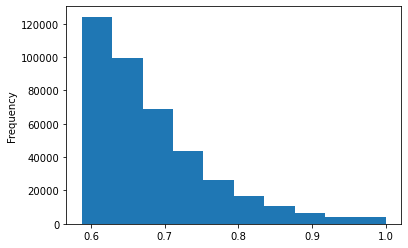

In [39]:
index_df["score"].plot(kind='hist')

In [45]:
print(index_df[1:3].value_counts())

id_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 id_2                                                                                                                                                                                                                                                                                                               

In [40]:
index_df.head(25)

,id_1,id_2,score
0,нелинейн метод: остаточн стоимост указа объект...,нелинейн метод: остаточн стоимост указа объект...,1.000001
1,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
2,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
3,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
4,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
5,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
6,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
7,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
8,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001
9,язык программирован основ введен настройк доку...,язык программирован основ введен настройк доку...,1.000001


In [47]:
dd = index_df[index_df["score"] < 0.75 ]
dd.head(25)

,id_1,id_2,score
70680,инфаркт ствол мозг сопровожда симптом поражен ...,рост неврином сторон ствол мозг мозжечк сопров...,0.749998
70681,есл откажет посеща работодателей снят учет пот...,отказ прав долж четк подлежа толкован сторон р...,0.749997
70682,адф рибозилциклаз гидролаз адф рибоз одноцепоч...,моно адф рибозилтрансфераз тип относ семейств ...,0.749993
70683,укажите перечислен ниж использ лечен больн дан...,как перечислен ниж заболеван необходим исключ ...,0.749992
70684,грушев водк сок лайм газирова вод вкус лайм ли...,ложек давлен черника ежевик ягод давлен ежевик...,0.749990
70685,беспокоиться волнова сочетаниях: мысль; идея; ...,смысл значение сут сочетаниях: мысли; мнение; ...,0.749990
70686,хорош встряхнут процед бока олд фэшн четверт н...,туд насыпьт ледян кубик хорошеньк встряхните,0.749990
70687,южнокитайск айс английск название: шотландск в...,зыбуч песк английск название: лондонск сух джи...,0.749984
70688,проведен медосмотров проверя способ работник р...,итог править суд текст проведен медосмотр спос...,0.749983
70689,как диагноз? правильн ответ: остр очагов пульп...,как перечислен ниж диагноз наибол вероят дан с...,0.749983


In [44]:
print(dd[11: 13].value_counts())

id_1                                                                                                                                                                                                                                                                                                                                                                            id_2                                                                                                                                                                                                                                                                                                                                                                                                score   
фосфорилаз осуществля фосфоролиз гликогена вследств расщепля глюкозо фосфата                                                                                                                                                               

In [43]:
print(dd[1:7].value_counts())

id_1                                                                                                                              id_2                                                                                                        score   
ягодный кекс водка финляндия скандинавские ягоды вишнёвый сок лаймовая газировка севен украшение слайс лимона билд источник: ://  ягодный тоник малиновая водка финляндия рэдберри тоник украшение слайс лимона билд источник: ://            0.899058    1
через мин после рождения состояние ребенка тяжелое счет нарастания дыхательных расстройств баллов шкале сильвермана               при рождении состояние ребенка тяжелое счет симптомов дыхательной недостаточности баллов шкале сильвермана  0.898563    1
теория системно динамической локализации впф править проблема локализации высших психических функций                              лурия для теории системной динамической локализации высших психических функций                              0.898560   

In [38]:
index_df.sample(frac=0.25)

,id_1,id_2,score
6303,содержание как открыть порт кому нужны доступн...,выбор номера править порт — это просто любое у...,0.579081
8778,терапевт опрашивает заместителей иногда нет до...,роджерса аутентичность терапевта безоценочное ...,0.539456
6623,как проводится диспансерное наблюдение подобны...,каких исследований необходимо начать обследова...,0.573454
14500,этом состоит наше преимущество этой причине на...,ведь это наглядный урок возможностей морфогене...,0.430413
13288,персональные странички современных учёных моно...,настоящее время изучением эпигенома занимается...,0.463298
...,...,...,...
5120,полярность цитоплазмы править замечательную сп...,удивительная способность планарии регенерации ...,0.600493
47,конечная сборка создает папку или папке вывода...,отладочная сборка создает папку или папке выво...,0.962474
2008,присвоение выполняется последним предложении и...,заметь что значение блока это значение последн...,0.690116
10806,игнорирование регистра работает только для лат...,без регистрации могут быть только эти граждане,0.507442


In [144]:
filter_large = index_df['score'] < 0.8
n = index_df.loc[filter_large]

In [146]:
n.head(30)

,id_1,id_2,score
4514,методики исследования нагляднообразного мышле...,"методики исследования внимания, процедура про...",0.799845
4515,"методики исследования внимания, процедура про...",методики исследования нагляднообразного мышле...,0.799845
4516,"методики исследования внимания, процедура про...",методики исследования нагляднообразного мышле...,0.799845
4517,"позаказный, попередельный и попроцессный мето...",попроцесный метод калькулирования себестоимос...,0.799774
4518,что такое сектор жёсткого диска?,для чего используется первый сектор жёсткого ...,0.799504
4519,# загружаем файл с бутсектором # необходимо д...,"(,) # устанавливаем корнем первый раздел перв...",0.799168
4520,номин,мн,0.799153
4521,номин,мн,0.799153
4522,();; ( : ): ; // выполняет склеивание списко...,") (, );; (: ): ; ;// возвращает перевёрнутый ...",0.799136
4523,или,или ///,0.798954


In [149]:
n.sample(frac=0.25)

,id_1,id_2,score
8497,"""выберите "" ""первая страница - это вступление,...",то же действие (скачивание) вы можете наблюда...,0.362792
8447,"литератураэндрю таненбаум, мартин ван стеен ра...",система кайзен-кост,0.373450
5933,частная фирма построена на экономическом конт...,причиной этой неэффективности бюрократии явля...,0.589860
6479,выгода для нашего простого примера может пока...,", но понять такой код было бы ещё сложнее",0.542922
8477,""" пули выбранное в таблицу рэнжей для обновлений",миссии для -режима ежедневно обновляются,0.367439
...,...,...,...
5747,структуры данных на базе статического массивап...,"простейшая очередь = ; = _: ;_, _: ;_: ; : ...",0.606884
5269,"кроме того маленькие ゃ я, ょ ё, ゅ ю используютс...",а для любой другой согласной нужно точно так ...,0.660075
8546,"каждая -миссия, кроме тренировки, делится на ...",состоит из двух секций: и в первой секции ка...,0.348747
5090,↑игровые валюты —,↑перчатки —,0.685201


<AxesSubplot:ylabel='Frequency'>

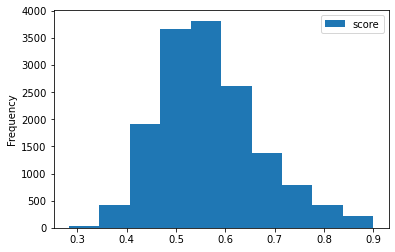

In [46]:
dd.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

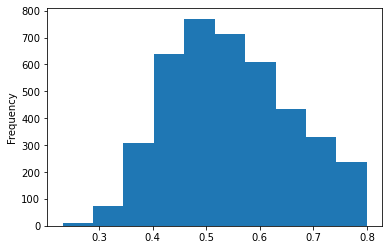

In [150]:
n["score"].plot(kind='hist')

In [ ]:
сохранение данных

In [49]:
index_df.to_csv('all_sent_transf.csv')